In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

In [2]:
# Temple resizing function
import numpy as np
#mport os
#import pandas as pd
#import random
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 

#import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# utils.py
###################################################################################
    
    
#Rescale to be 64 frames
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim]) 
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new

def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")
    plt.savefig(filename)

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:

random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16 # ?? In the python notebook is 64, here is 16...
        self.data_dir = '/content/SHREC'
C = Config()

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...]) #tensorflow method 
    x = tf.image.resize(x,size=[H,W]) 
    return x

#calculate M_k_slow and M_k_fast
def pose_motion(P,frame_l):
    print("P type is:")
    print(type(P))
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)  #M_slow_[1,2,...,K - 1]
    P_fast = Lambda(lambda x: x[:,::2,...])(P) # S_0, S_2, S_5 ,... is P 1D?
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast) #M_fast_[1,2,...,K/2 - 1]
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    # Modeling Joint Correlations by an Embedding
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


In [6]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [7]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)
DD_Net.summary()


P type is:
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 231)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4, 128)       119392      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pool

In [10]:

Train = pickle.load(open("/content/sample_data/train.pkl", "rb"))
Test = pickle.load(open("/content/sample_data/test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████| 1960/1960 [00:16<00:00, 120.69it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:06<00:00, 121.72it/s]


In [15]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Epoch 1/600
1/1 [==============================] - 6s 6s/step - loss: 0.1261 - accuracy: 0.9679 - val_loss: 1.0709 - val_accuracy: 0.6690
Epoch 2/600
1/1 [==============================] - 1s 947ms/step - loss: 0.1574 - accuracy: 0.9566 - val_loss: 1.2607 - val_accuracy: 0.6250
Epoch 3/600
1/1 [==============================] - 1s 958ms/step - loss: 0.1408 - accuracy: 0.9577 - val_loss: 1.4156 - val_accuracy: 0.5905
Epoch 4/600
1/1 [==============================] - 1s 967ms/step - loss: 0.1409 - accuracy: 0.9602 - val_loss: 1.4450 - val_accuracy: 0.5952
Epoch 5/600
1/1 [==============================] - 1s 951ms/step - loss: 0.1424 - accuracy: 0.9628 - val_loss: 1.3709 - val_accuracy: 0.6071
Epoch 6/600
1/1 [==============================] - 1s 953ms/step - loss: 0.1475 - accuracy: 0.9566 - val_loss: 1.2580 - val_accuracy: 0.6274
Epoch 7/600
1/1 [==============================] - 1s 965ms/step - loss: 0.1411 - accuracy: 0.9597 - val_loss: 1.2253 - val_accuracy: 0.6369
Epoch 8/600
1/1 

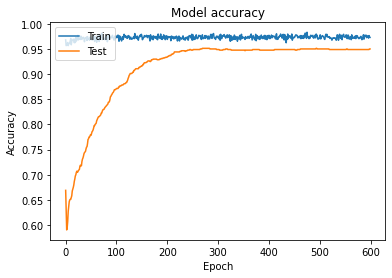

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()